<a href="https://colab.research.google.com/github/ninadaptegit/customYoloCatDetection/blob/main/catdetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import kagglehub
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import v2
from pathlib import Path
import xml.etree.ElementTree as ET
from matplotlib import pyplot as plt
import numpy as np
import torchvision.transforms as T

# Get the data

In [3]:
path = kagglehub.dataset_download("andrewmvd/dog-and-cat-detection")
# path = "/root/.cache/kagglehub/datasets/andrewmvd/dog-and-cat-detection/versions/1"
print(path)

100%|██████████| 1.03G/1.03G [00:11<00:00, 94.2MB/s]

Extracting files...


/root/.cache/kagglehub/datasets/andrewmvd/dog-and-cat-detection/versions/1


In [4]:
directory_path = Path(path)
ann_path = Path(directory_path / "annotations")
img_path = Path(directory_path / "images")
files = [f for f in ann_path.iterdir() if f.is_file()]


# Create a csv file with image name, class, x,y,width,height for easier loading

In [5]:
from PIL import Image

In [6]:

df = pd.DataFrame(columns=["image_name", "x_mid", "y_mid", "width", "height"])
for file_name in files:
  tree = ET.parse(ann_path / file_name)
  root = tree.getroot()
  obj = root.find('object')
  class_name = obj.find('name').text
  bndbox = obj.find('bndbox')
  xmin = int(bndbox.find('xmin').text)
  ymin = int(bndbox.find('ymin').text)
  xmax = int(bndbox.find('xmax').text)
  ymax = int(bndbox.find('ymax').text)

  # Going to skip dog class to avoid memory problems
  if class_name == "dog":
    continue

  x_center = ((xmin + xmax) / 2)
  y_center = ((ymin + ymax) / 2)
  box_width = (xmax - xmin)
  box_height = (ymax - ymin)

  df.loc[len(df)] = [file_name.stem+'.png', x_center,y_center,box_width,box_height ]


In [7]:
df.to_csv("data.csv", index=False)

In [8]:
df = pd.read_csv('data.csv')

# Custom Dataset to load the images and preprocess targets in required yolov1 format

In [9]:
class CatDataset(torch.utils.data.Dataset):
  def __init__(self, csv_file, root_dir, transform=None):

        # The csv file with image name and info
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        # Transform to apply on train and test using albumentations though not using complex to avoid y_truth problems.
        self.transform = transform
        # 7 cells row and col.
        self.grid=7
  def __len__(self):
        return len(self.data)

  def __getitem__(self, idx):

        img_name = self.data.iloc[idx, 0]
        img_path = self.root_dir / img_name

        # Convert to rgb format if greyscale images are present, (They are not)
        image = Image.open(img_path).convert("RGB")

        # Create a empty torch array of zeros of size (7,7,6) for 6 classes per cell aks : (objectness , x center, y center , class probabilities)
        target = torch.zeros(size=(self.grid,self.grid,6))
        width = image.width
        height = image.height

        x_center = self.data.iloc[idx, 1]
        y_center = self.data.iloc[idx, 2]
        box_width = self.data.iloc[idx, 3]
        box_height = self.data.iloc[idx, 4]

        # Normalize the data wrt to the image width and height
        x_center = x_center / width
        y_center = y_center / height
        box_width = box_width / width
        box_height = box_height / height

        bbox = [x_center, y_center, box_width, box_height]

        # Convert to np array as its required for albumentations transformations.
        image = np.array(image)

        if self.transform:
          augmented = self.transform(
              image=image,
              bboxes=[bbox],
              # Only cat class used
              class_labels=[0]
          )
          image = augmented['image']
          bbox = augmented['bboxes'][0]
        else:
            image = T.ToTensor()(image)



        target = torch.zeros((self.grid, self.grid, 6))
        x, y, w, h = bbox
        # Get the cell number of the grid where object exists
        i = int(self.grid * x)
        j = int(self.grid * y)

        # Assign 1 to objectness score and class for the object cell.
        target[j, i, 0] = 1       # This is objectness score
        target[j, i, 1:5] = torch.tensor([x, y, w, h])
        target[j, i, 5] = 1       # Only 1 class : Cat ... Dog is skipped



        return image, target



In [10]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Transform to take both bounding box and image into consideration

In [11]:
transform = A.Compose([
    A.Resize(448, 448),

    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
],
bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

# Divide into train and test

In [12]:
from torch.utils.data import random_split

In [13]:
dataset = CatDataset(csv_file="data.csv", root_dir=img_path, transform=transform)
train_size = int(0.8*len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Custom Conv model for detection

In [14]:
import torch
import torch.nn as nn

import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import ResNet34_Weights

class YOLOResNet(nn.Module):
    def __init__(self, S=7, C=1, B=1):

        super().__init__()
        self.S = S
        self.C = C
        self.B = B


        output_channels = self.B * 5 + self.C  # 6 total


        resnet = models.resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)


        self.features = nn.Sequential(*list(resnet.children())[:-2])


        self.head = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),


            nn.MaxPool2d(2, 2), # [B, 512, 14, 14] -> [B, 512, 7, 7]


            nn.Conv2d(512, output_channels, kernel_size=1) # [B, 512, 7, 7] -> [B, 6, 7, 7]
        )

    def forward(self, x):
        """
        Forward pass through the network.
        Input shape: [Batch_size, 3, 448, 448]
        """
        x = self.features(x)

        x = self.head(x)

        # Permute to get standard YOLO output shape [B, S, S, (B*5+C)]
        x = x.permute(0, 2, 3, 1) # [B, 7, 7, 6]
        # x = x.clone()  # avoid in-place ops if needed
        x[..., 0] = torch.sigmoid(x[..., 0])  # objectness
        x[..., 1:5] = torch.sigmoid(x[..., 1:5])  # bbox
        x[..., 5] = torch.sigmoid(x[..., 5])  # class
        return x

device = "cuda" if torch.cuda.is_available() else "cpu"

scratch = YOLOResNet(S=7, C=1, B=1).to(device)
# for param in scratch.features.parameters():
#     param.requires_grad = False



Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 183MB/s]


In [15]:
# 32,7,7,6
def customloss(output,target, lambda_coord=5, lambda_noobj=0.5):
    mse = nn.MSELoss(reduction='sum')

    obj_mask = target[:, :, :, 0] == 1
    noobj_mask = target[:, :, :, 0] == 0

    loss_xy = mse(output[obj_mask][:, 1:3], target[obj_mask][:, 1:3])

    pred_wh = torch.sqrt(torch.clamp(output[obj_mask][:, 3:5], min=1e-6))
    true_wh = torch.sqrt(torch.clamp(target[obj_mask][:, 3:5], min=1e-6))
    loss_wh = mse(pred_wh, true_wh)

    loss_obj = mse(output[obj_mask][:, 0], target[obj_mask][:, 0])
    loss_noobj = mse(output[noobj_mask][:, 0], target[noobj_mask][:, 0])

    loss_cls = mse(output[obj_mask][:, 5], target[obj_mask][:, 5])

    total_loss = (
        lambda_coord * (loss_xy + loss_wh) +
        loss_obj +
        lambda_noobj * loss_noobj +
        loss_cls
    )

    return total_loss

In [16]:
device

'cuda'

In [17]:
optimizer = torch.optim.Adam(scratch.parameters(), lr=0.001)
def compute_iou(box1, box2):

    box1_x1 = box1[..., 0] - box1[..., 2] / 2
    box1_y1 = box1[..., 1] - box1[..., 3] / 2
    box1_x2 = box1[..., 0] + box1[..., 2] / 2
    box1_y2 = box1[..., 1] + box1[..., 3] / 2

    box2_x1 = box2[..., 0] - box2[..., 2] / 2
    box2_y1 = box2[..., 1] - box2[..., 3] / 2
    box2_x2 = box2[..., 0] + box2[..., 2] / 2
    box2_y2 = box2[..., 1] + box2[..., 3] / 2

    inter_x1 = torch.max(box1_x1, box2_x1)
    inter_y1 = torch.max(box1_y1, box2_y1)
    inter_x2 = torch.min(box1_x2, box2_x2)
    inter_y2 = torch.min(box1_y2, box2_y2)

    inter_area = torch.clamp(inter_x2 - inter_x1, min=0) * torch.clamp(inter_y2 - inter_y1, min=0)

    box1_area = (box1_x2 - box1_x1) * (box1_y2 - box1_y1)
    box2_area = (box2_x2 - box2_x1) * (box2_y2 - box2_y1)

    union_area = box1_area + box2_area - inter_area

    iou = inter_area / (union_area + 1e-6)
    return iou

In [18]:
import torch
from tqdm import tqdm

def train(model, train_loader, test_loader, optimizer, loss_fn, device, epochs=2):
    model.to(device)

    train_loss_list = []
    train_iou_list = []
    test_loss_list = []
    test_iou_list = []

    for epoch in range(epochs):
        model.train()
        train_total_loss = 0
        train_total_iou = 0
        train_num_objects = 0

        loop = tqdm(train_loader, leave=False)
        for images, targets in loop:
            images = images.to(device)
            targets = targets.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, targets)
            train_total_loss += loss.item()

            obj_mask = targets[..., 0] == 1
            if obj_mask.sum() > 0:
                pred_boxes = outputs[obj_mask][:, 1:5]
                true_boxes = targets[obj_mask][:, 1:5]
                ious = compute_iou(pred_boxes, true_boxes)
                train_total_iou += ious.sum().item()
                train_num_objects += ious.numel()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
            loop.set_postfix(loss=loss.item())

        avg_train_loss = train_total_loss / len(train_loader)
        avg_train_iou = train_total_iou / train_num_objects if train_num_objects > 0 else 0

        # Evaluation
        model.eval()
        test_total_loss = 0
        test_total_iou = 0
        test_num_objects = 0

        with torch.inference_mode():
            for images, targets in test_loader:
                images = images.to(device)
                targets = targets.to(device)

                outputs = model(images)
                loss = loss_fn(outputs, targets)
                test_total_loss += loss.item()

                obj_mask = targets[..., 0] == 1
                if obj_mask.sum() > 0:
                    pred_boxes = outputs[obj_mask][:, 1:5]
                    true_boxes = targets[obj_mask][:, 1:5]
                    ious = compute_iou(pred_boxes, true_boxes)
                    test_total_iou += ious.sum().item()
                    test_num_objects += ious.numel()

        avg_test_loss = test_total_loss / len(test_loader)
        avg_test_iou = test_total_iou / test_num_objects if test_num_objects > 0 else 0

        train_loss_list.append(avg_train_loss)
        train_iou_list.append(avg_train_iou)
        test_loss_list.append(avg_test_loss)
        test_iou_list.append(avg_test_iou)

        print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f}, Train IoU: {avg_train_iou:.4f} | "
              f"Test Loss: {avg_test_loss:.4f}, Test IoU: {avg_test_iou:.4f}")

    return train_loss_list, train_iou_list, test_loss_list, test_iou_list


In [61]:
train_loss_list, train_iou_list, test_loss_list, test_iou_list = train(scratch, train_loader, test_loader, optimizer, customloss, device, epochs=25)

Epoch 1 | Train Loss: 67.0527, Train IoU: 0.6058 | Test Loss: 63.6746, Test IoU: 0.6139


Epoch 2 | Train Loss: 65.8074, Train IoU: 0.6737 | Test Loss: 62.7802, Test IoU: 0.6365


Epoch 3 | Train Loss: 64.8373, Train IoU: 0.7305 | Test Loss: 62.3690, Test IoU: 0.6287


Epoch 4 | Train Loss: 64.3725, Train IoU: 0.7590 | Test Loss: 62.0008, Test IoU: 0.6737


Epoch 5 | Train Loss: 64.1238, Train IoU: 0.7886 | Test Loss: 61.7353, Test IoU: 0.6997


Epoch 6 | Train Loss: 64.0820, Train IoU: 0.7990 | Test Loss: 61.9695, Test IoU: 0.6890


Epoch 7 | Train Loss: 63.9528, Train IoU: 0.8161 | Test Loss: 61.7086, Test IoU: 0.6974


Epoch 8 | Train Loss: 63.7993, Train IoU: 0.8377 | Test Loss: 61.6547, Test IoU: 0.7061


Epoch 9 | Train Loss: 63.6823, Train IoU: 0.8586 | Test Loss: 61.6400, Test IoU: 0.7077


Epoch 10 | Train Loss: 63.6028, Train IoU: 0.8742 | Test Loss: 61.4726, Test IoU: 0.7114


Epoch 11 | Train Loss: 63.5201, Train IoU: 0.8940 | Test Loss: 61.4960, Test IoU: 0.7145


Epoch 12 | Train Loss: 63.4781, Train IoU: 0.9050 | Test Loss: 61.4923, Test IoU: 0.7176


Epoch 13 | Train Loss: 63.5085, Train IoU: 0.8924 | Test Loss: 61.5837, Test IoU: 0.7103


Epoch 14 | Train Loss: 63.5396, Train IoU: 0.8895 | Test Loss: 61.4178, Test IoU: 0.7192


Epoch 15 | Train Loss: 63.4811, Train IoU: 0.9046 | Test Loss: 61.4732, Test IoU: 0.7154


Epoch 16 | Train Loss: 63.4811, Train IoU: 0.9045 | Test Loss: 61.4227, Test IoU: 0.7218


Epoch 17 | Train Loss: 63.4728, Train IoU: 0.9047 | Test Loss: 61.3903, Test IoU: 0.7168


Epoch 18 | Train Loss: 63.4878, Train IoU: 0.8957 | Test Loss: 61.5875, Test IoU: 0.7191


Epoch 19 | Train Loss: 63.4878, Train IoU: 0.8968 | Test Loss: 61.4530, Test IoU: 0.7229


Epoch 20 | Train Loss: 63.4476, Train IoU: 0.9103 | Test Loss: 61.4207, Test IoU: 0.7248


Epoch 21 | Train Loss: 63.4350, Train IoU: 0.9155 | Test Loss: 61.4464, Test IoU: 0.7196


Epoch 22 | Train Loss: 63.4514, Train IoU: 0.9134 | Test Loss: 61.3983, Test IoU: 0.7236


Epoch 23 | Train Loss: 63.4379, Train IoU: 0.9191 | Test Loss: 61.5141, Test IoU: 0.7172


Epoch 24 | Train Loss: 63.4541, Train IoU: 0.9143 | Test Loss: 61.4474, Test IoU: 0.7183


Epoch 25 | Train Loss: 63.4332, Train IoU: 0.9073 | Test Loss: 61.4435, Test IoU: 0.7193


In [52]:
def plot_gt_and_top_pred(X, y_true, y_pred, grid_size=7):
    import matplotlib.pyplot as plt
    import torchvision.transforms as T
    import matplotlib.patches as patches

    # Unnormalize the image (ImageNet stats)
    unnormalize = T.Normalize(mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
                              std=[1 / 0.229, 1 / 0.224, 1 / 0.225])
    X = unnormalize(X)
    X = torch.clamp(X, 0, 1)

    img = X.permute(1, 2, 0).cpu().numpy()

    fig, ax = plt.subplots(1)
    ax.imshow(img)

    # Draw ground truth boxes (green)
    for i in range(grid_size):
        for j in range(grid_size):
            if y_true[j, i, 0] > 0:
                x, y_center, w, h = y_true[j, i, 1:5]
                abs_x = (i + x) / grid_size
                abs_y = (j + y_center) / grid_size
                abs_w = w
                abs_h = h

                x0 = (abs_x - abs_w / 2) * 448
                y0 = (abs_y - abs_h / 2) * 448
                width = abs_w * 448
                height = abs_h * 448

                rect = patches.Rectangle((x0, y0), width, height,
                                         linewidth=2, edgecolor='lime', facecolor='none', label='Ground Truth')
                ax.add_patch(rect)

    # Get predicted box with highest objectness
    objectness = y_pred[..., 0]
    max_val, max_idx = torch.max(objectness.view(-1), dim=0)
    if max_val > 0:
        flat_idx = max_idx.item()
        j = flat_idx // grid_size  # row
        i = flat_idx % grid_size   # col

        x, y_center, w, h = y_pred[j, i, 1:5]
        abs_x = (i + x) / grid_size
        abs_y = (j + y_center) / grid_size
        abs_w = w
        abs_h = h

        x0 = (abs_x - abs_w / 2) * 448
        y0 = (abs_y - abs_h / 2) * 448
        width = abs_w * 448
        height = abs_h * 448

        rect = patches.Rectangle((x0, y0), width, height,
                                 linewidth=2, edgecolor='red', facecolor='none', label='Top Prediction')
        ax.add_patch(rect)

    # Add legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc="upper right")

    plt.axis('off')
    plt.show()


In [ ]:
def plot_losses(train_losses, test_losses):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs, test_losses, label='Test Loss', marker='x')

    plt.title('Training vs Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [68]:
torch.save(scratch.state_dict(), "scratch_weightsv2.pth")

In [21]:
model = YOLOResNet(S=7, C=1, B=1).to(device)

In [26]:
model.load_state_dict(torch.load("scratch_weightsv2.pth", map_location=device))

<All keys matched successfully>

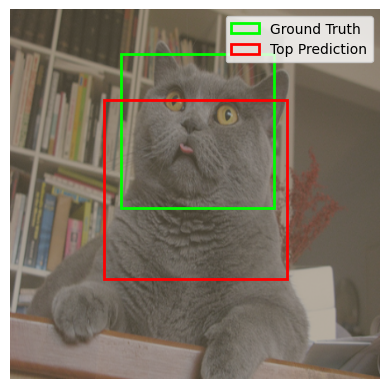

In [64]:
for X_batch, y_batch in train_loader:
    X_hold = X_batch[0].to(device)           # [3, 448, 448]
    y_hold = y_batch[0]                      # [7, 7, 6]

    with torch.no_grad():
        y_pred = model(X_hold.unsqueeze(0))  # Add batch dim → [1, 3, 448, 448]

    y_hold_pred = y_pred[0].cpu()            # Remove batch dim, move to CPU

    plot_gt_and_top_pred(X_hold.cpu(), y_hold, y_hold_pred, grid_size=7)
    break